In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def detrend(da, dim='time', deg=1):
    # detrend the dataset da along the time dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def find_nino(ts_nino34):
    
    '''
    The function looks for 6 consecutive months in which the index has been above 0.4 (Nino) or below 
    -0.4 (Nina). Once the events have been individuated, it creates a list containing the dates 
    corresponding to the events. 
    
    It returns:
    1) A dataarray containing monthly time series of Nino 3.4 index
    2) The list of dates corresponding to those months which have faced a El Nino event
    3) The list of dates corresponding to those months which have faced a La Nina event

    '''
    
    detect_nino = []
    dates_nino = []
    detect_nina = []
    dates_nina = []
    
    for i in range(0,len(ts_nino34)):
        if ts_nino34[i] > 0.4:
            # Put the date in which an event > 0.4 was detected into a list
            detect_nino.append(ts_nino34[i].time.values)
        else:
            if len(detect_nino) > 5:
                # If the list contains more than 5 months, 
                dates_nino.append(detect_nino)
            detect_nino = []

        if ts_nino34[i] < -0.4:
            detect_nina.append(ts_nino34[i].time.values)
        else:
            if len(detect_nina) > 5:
                dates_nina.append(detect_nina)
            detect_nina = []
            
    flat_nino = [dat for innerList in dates_nino for dat in innerList]
    flat_nina = [dat for innerList in dates_nina for dat in innerList]
    
    return flat_nino, flat_nina

def find_enso(sst):
    
    '''
    
    sst is a dataarray containing the time series of global sst 
    
    '''
    # First I select the region used to define Nino3.4
    sst34 = sst.sel(lat=slice(-5,5), lon= slice(190,240))
    
    # Detrend, deseasonalize data and make field mean, make rolling mean on the time-series
    sst34 = detrend(sst34)
    mon_deseason = (sst34.groupby('time.month') - sst34.groupby('time.month').mean()).mean(dim=['lon','lat'])
    anomalies = mon_deseason - mon_deseason.mean(dim=['time'])
    nino34 = anomalies.rolling(time=6,center=True).mean()
    
    # Get the timeseries of Nino3.4 index and retrieves the dates corresponding to El Nino/La Nina events
    nino_date, nina_date = find_nino(nino34)
    
    # For a graphical visualization of the results
    fig,ax = plt.subplots(figsize=(11,7))
    ax.plot(nino34.time,nino34)
    plt.plot(nino34.sel(time=nino_date).time,nino34.sel(time=nino_date),'o',markersize=5)
    plt.plot(nino34.sel(time=nina_date).time,nino34.sel(time=nina_date),'o',markersize=5)
    plt.axhline(y=0.4,color='k')
    plt.axhline(y=-0.4,color='k')
    plt.xlim(sst.isel(time=0).time, sst.isel(time=-1).time)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Nino3.4 index', fontsize=12)
    
    
    return nino34, nino_date, nina_date
    

In [11]:
path = "/home/esp-shared-a/Distribution/Workshops/cli_dy_summer_school_2023/observations/surface/era5/era5_sst_1940_2022_1deg.nc"
sst = xr.open_dataarray(path)

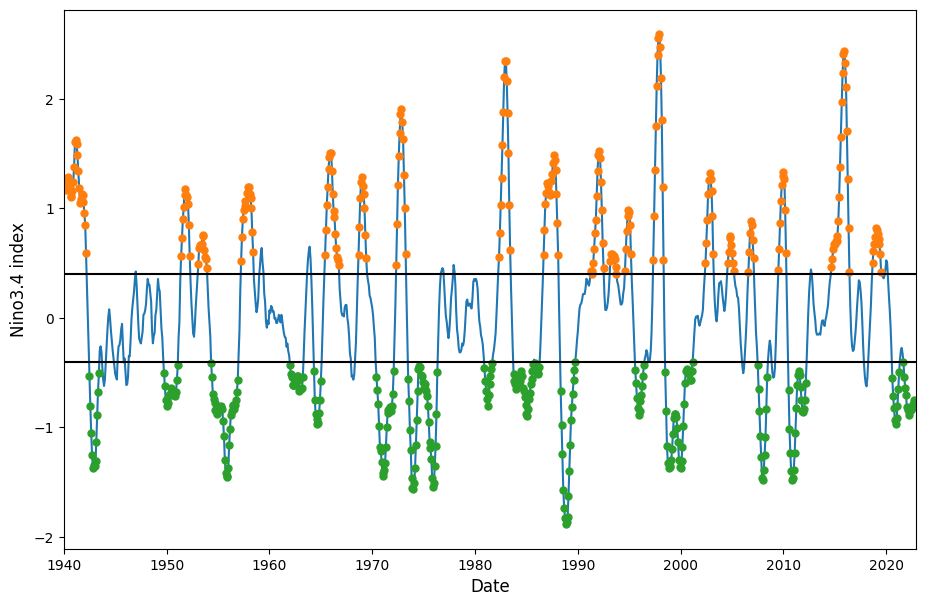

In [12]:
nino34,nino_date,nina_date = find_enso(sst)